In [2]:
import torch
import numpy as np
import cv2
import PIL
from io import BytesIO
import requests
from utils import split_image
from typing import List, Optional, Tuple, Union
import matplotlib.pyplot as plt

In [1]:
!pip3 install -e .

Obtaining file:///diffusers_hairstyle_transfer
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for diffusers (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.17.0.dev0-0.editable-py3-none-any.whl size=10527 sha256=1325d08736af3fffaece39d57f91b93f0a0e3b895c368d566c195ac59eaa1c91
  Stored in directory: /tmp/pip-ephem-wheel-cache-93lzpoag/wheels/0c/70/26/b2908a33ed5f8ac1a7f73651c6b155046495e5eae9938d17ef
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.17.0.dev0
    Uninstalling diffusers-0.17.0.dev0:
      Successfully uninstalled diffusers-0.17.0.dev0


In [8]:
from io import BytesIO

import torch

import PIL
import requests
from diffusers import RePaintPipelineNew, RePaintSchedulerNew


def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")

original_image = cv2.imread('hair_samples/00000.jpg')
_, _,mask_image = split_image(original_image,return_mask=True)
mask_image = (mask_image*255).astype(np.uint8)
hair_image = cv2.imread('hair_samples/00005.jpg')
original_image = PIL.Image.fromarray(original_image[:,:,::-1].astype(np.uint8))
mask_image = PIL.Image.fromarray(mask_image)
hair_image = PIL.Image.fromarray(hair_image[:,:,::-1].astype(np.uint8))

# Load the RePaint scheduler and pipeline based on a pretrained DDPM model
scheduler = RePaintSchedulerNew.from_pretrained("google/ddpm-ema-celebahq-256")
scheduler.config.num_train_timesteps = 250
scheduler.num_inference_steps = 100
scheduler.set_timesteps(num_inference_steps=100)
pipe = RePaintPipelineNew.from_pretrained("google/ddpm-ema-celebahq-256", scheduler=scheduler)
pipe = pipe.to("cuda")

generator = torch.Generator(device="cuda").manual_seed(0)
output = pipe(
    hair_image = hair_image,
    image=original_image,
    mask_image=mask_image,
    num_inference_steps=100,
    eta=0.0,
    jump_length=10,
    jump_n_sample=10,
    generator=generator,
)
inpainted_image = output.images[0]

Number of faces detected: 1
Detection 0: Left: 46 Top: 81 Right: 201 Bottom: 236
Part 0: (58, 134), Part 1: (59, 150) ...


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/1720 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

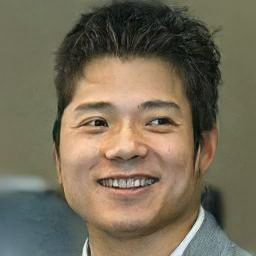

In [9]:
inpainted_image

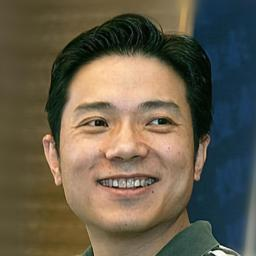

In [18]:
original_image

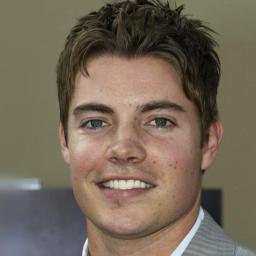

In [10]:
hair_image

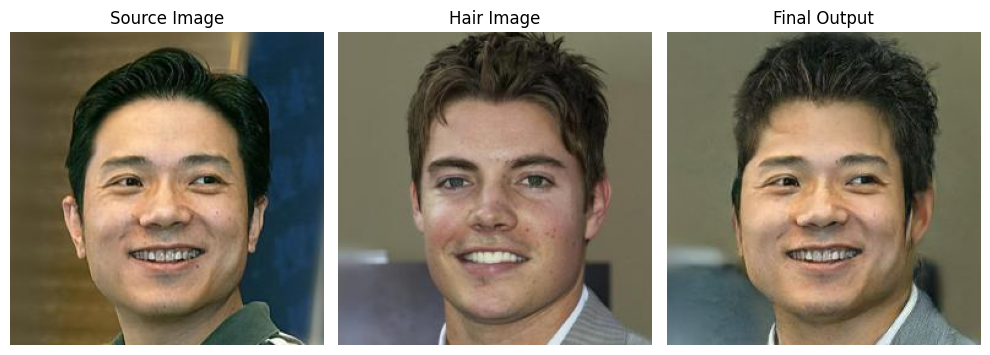

In [13]:
# Create a figure with three subplots
fig, axs = plt.subplots(1, 3,figsize=(10,5))
# Remove ticks and axes for all subplots
for ax in axs:
    ax.axis("off")
# Plot the first image
axs[0].imshow(original_image)
axs[0].set_title("Source Image")

# Plot the second image
axs[1].imshow(hair_image)
axs[1].set_title("Hair Image")

# Plot the third image
axs[2].imshow(inpainted_image)
axs[2].set_title("Final Output")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()